In [24]:
from pathlib import Path
from urllib.request import urlretrieve
import zipfile
from scipy.misc import imread
from scipy.ndimage.interpolation import zoom#
import numpy as np
def fetch_cropped_yaleb(data_folder, zooming=0.5, max_n_subjects=None):
    """Returns a dictionary of paths
    
    Parameters
    ----------
    data_folder: string
    zooming: float, optional, default is 0.5
        factor by which to resize the images
    max_n_subjects: {None, int}, optional, default is None
        if not None, only the first max_n_subjects are returned
    
    Returns
    -------
    dict: {
        subjects_1: {'images': [image_1, ... image_N],
               'ambient': image_ambient,
        }
    }
    
    images are stored as numpy arrays
    """
    url = 'http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip'
    yaleb_path = Path(data_folder).joinpath('cropped_yaleb')
    
    if not yaleb_path.joinpath('CroppedYale').exists():
        yaleb_path.mkdir(parents=True)
    
    # If not already unzip, do it
    if not list(yaleb_path.iterdir()):
        zip_path = yaleb_path.joinpath('yaleb.zip')
        
        # If zip not already downloaded, download it
        if not zip_path.exists():
            urlretrieve(url, zip_path.as_posix())
        
        zfile = zipfile.ZipFile(zip_path.as_posix())
        zfile.extractall(path=yaleb_path.as_posix())

    yaleb = {}
    for folder_path in yaleb_path.joinpath('CroppedYale').iterdir():
        if max_n_subjects is not None and len(yaleb) > max_n_subjects:
            return yaleb
        
        if not folder_path.is_dir():
            continue
            
        video_name = folder_path.name
        paths = sorted(list(folder_path.glob('*.pgm')))
        images = []
        for path in paths:
            if 'Ambient' in path.name:
                ambient = imread(path.as_posix())
            else:
                images.append(zoom(imread(path.as_posix()), zooming)[None, ...])
                
        data = {'images':np.concatenate(images),
        'ambient':ambient}
        yaleb[video_name] = data

    return yaleb

In [146]:
dataset_path = '/Users/martinawu/Desktop/course-project-proposal-inf/mid/data/tensorly_data/'

In [154]:
data = fetch_cropped_yaleb(dataset_path, zooming=0.3, max_n_subjects=5)
A=data['yaleB33']['images']
A.shape

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Applications/anaconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(64, 58, 50)

In [223]:
X = np.concatenate([data[key]['images'] for key in data], axis=0)
X.shape

(384, 58, 50)

In [149]:
X = X.astype(np.float64)
X -= X.mean()

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualise_images(X, n_images, n_columns, randomise=True):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')

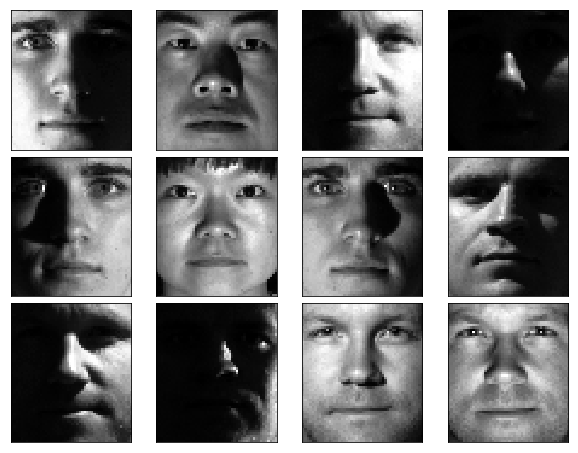

In [162]:
visualise_images(X,12, 4)
plt.savefig('./face.png')

In [103]:
import random
def salt_and_pepper_noise(img, proportion=0.05):
    noise_img =img
    height,width =noise_img.shape[0],noise_img.shape[1]
    num = int(height*width*proportion)#多少个像素点添加椒盐噪声
    for i in range(num):
        w = random.randint(0,width-1)
        h = random.randint(0,height-1)
        if random.randint(0,1) ==0:
            noise_img[h,w] =0
        else:
            noise_img[h,w] = 255
    return noise_img

In [156]:
for i in range(384):
    X[i]=salt_and_pepper_noise(X[i], proportion=0.1)
X = np.array(X, dtype=np.float64) 

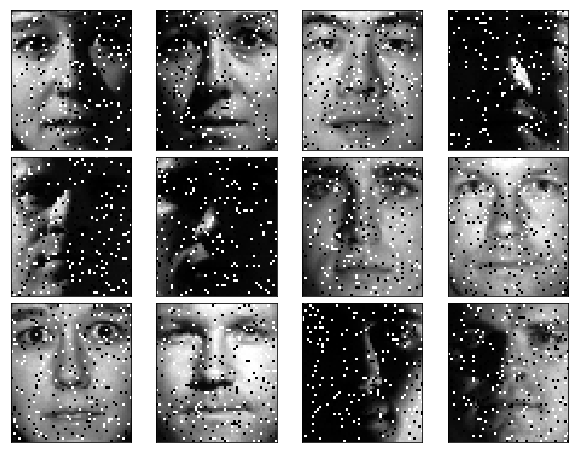

In [157]:
visualise_images(X, 12, 4)
plt.savefig('./face_with_salt_and_pepper_noise.png')

In [73]:
from tensorly.decomposition import robust_pca

In [158]:
low_rank_part, sparse_part = robust_pca(X, reg_E=0.04, learning_rate=1.2, n_iter_max=20)

In [159]:
def visualise_rpca(X, low_rank_part, sparse_part, n_images=10):
    """A little helper function to visualise the result of tensor RPCA
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]

    fig = plt.figure(figsize=(10, 2*n_images))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        cmap = plt.cm.Greys_r

        ax = fig.add_subplot(n_images, 4, 4*i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Original')

        ax = fig.add_subplot(n_images, 4, 4*i + 2, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Low-rank')

        ax = fig.add_subplot(n_images, 4, 4*i + 3, xticks=[], yticks=[])
        ax.imshow(sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Sparse')

        ax = fig.add_subplot(n_images, 4, 4*i + 4, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e]+sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Reconstruction')

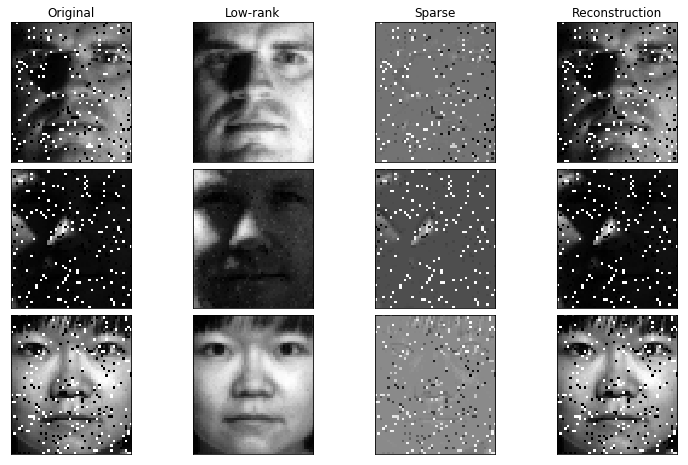

In [160]:
visualise_rpca(X, low_rank_part, sparse_part, n_images=3)
plt.savefig('./Tensor_PCA.png')

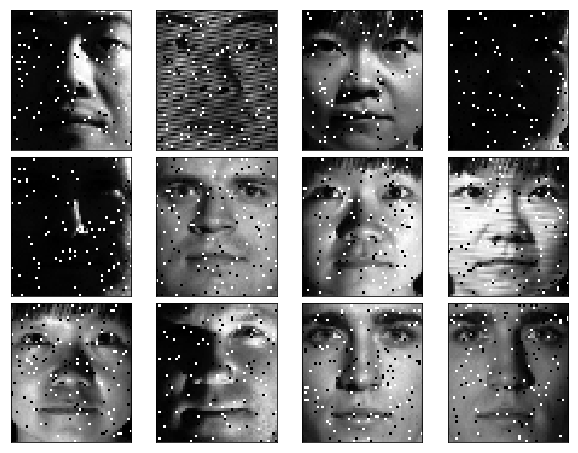

In [243]:
#random_noise(image, mode='gaussian', seed=None, clip=True, **kwargs)
#modestr, optional
#One of the following strings, selecting the type of noise to add:

#‘gaussian’ Gaussian-distributed additive noise.

#‘localvar’ Gaussian-distributed additive noise, with specified
#local variance at each point of image.

#‘poisson’ Poisson-distributed noise generated from the data.

#‘salt’ Replaces random pixels with 1.

#‘pepper’ Replaces random pixels with 0 (for unsigned images) or
#-1 (for signed images).

#‘s&p’ Replaces random pixels with either 1 or low_val, where
#low_val is 0 for unsigned images or -1 for signed images.

#‘speckle’ Multiplicative noise using out = image + n*image, where
#n is uniform noise with specified mean & variance.
#import skimage
X2 = skimage.util.random_noise(X,mode='s&p',seed=None,clip=True)
visualise_images(X2, 12, 4)

plt.savefig('./salt_and_pepper_noise.png')
#X3=skimage.util.random_noise(X,mode='speckle',seed=None,clip=True)
#visualise_images(X3, 12, 4)
#plt.savefig('./Gaussian-distributed additive noise.png')

In [171]:
low_rank_part, sparse_part = robust_pca(X2, reg_E=0.04, learning_rate=1.4, n_iter_max=40)

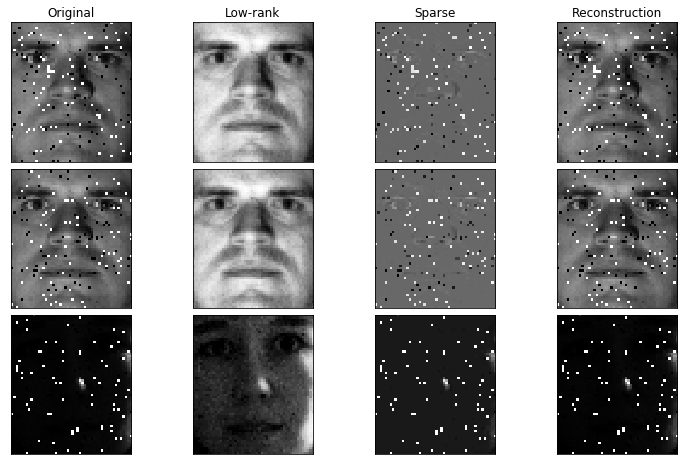

In [172]:
visualise_rpca(X2, low_rank_part, sparse_part, n_images=3)


Converged in 77 iterations


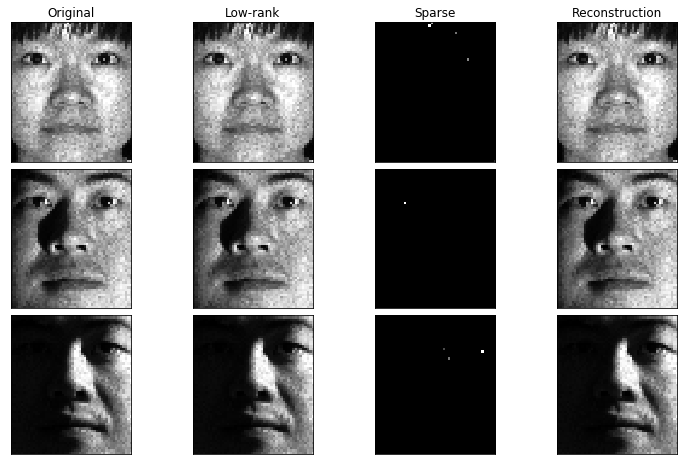

In [178]:
low_rank_part, sparse_part = robust_pca(X3, reg_E=0.4, learning_rate=1.4, n_iter_max=80)
visualise_rpca(X3, low_rank_part, sparse_part, n_images=3)

In [244]:
#mask
for i in range(X2.shape[0]):
    random.seed()
    x=random.randint(1,48)
    y=random.randint(1,40)
    #print(x,y)
    X2[i,x:x+10,y:y+10]=np.zeros((10,10))

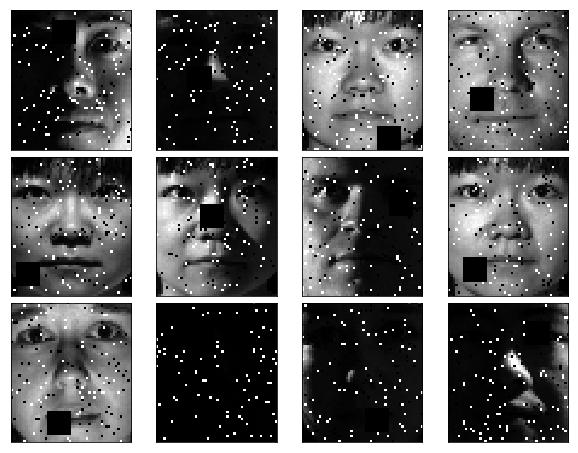

In [245]:
visualise_images(X2, 12, 4)
plt.savefig('./salt_and_pepper_noise+mask.png')

In [248]:
X2 = np.array(X2, dtype=np.float64) 
low_rank_part, sparse_part = robust_pca(X2, reg_E=0.04, learning_rate=1.8, n_iter_max=80)


Converged in 41 iterations


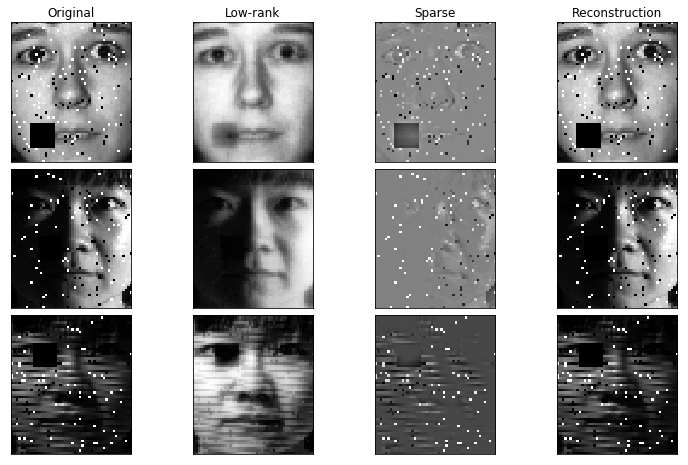

In [249]:
visualise_rpca(X2, low_rank_part, sparse_part, n_images=3)

In [250]:
from urllib.request import urlretrieve
video_filename = 'highwayII_raw.AVI'
urlretrieve ("http://cvrr.ucsd.edu/aton/shadow/data/highwayII_raw.AVI", video_filename)

('highwayII_raw.AVI', <http.client.HTTPMessage at 0xb1f249c50>)

In [252]:
from scipy.misc import imresize

In [254]:
from iopy2.collection import ImageCollection

In [257]:
collection = ImageCollection.from_video_filename(video_filename, image_to_gray=True, image_dtype=np.float)

In [260]:
collection

ImageCollection, collection of 500 elements, cachine disabled..

In [261]:
def resize(image):
    return imresize(image, 0.5)

In [262]:
Y = collection.to_matrix(flatten_images=False, apply_fun=resize)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [263]:
Y.shape

(500, 120, 160)

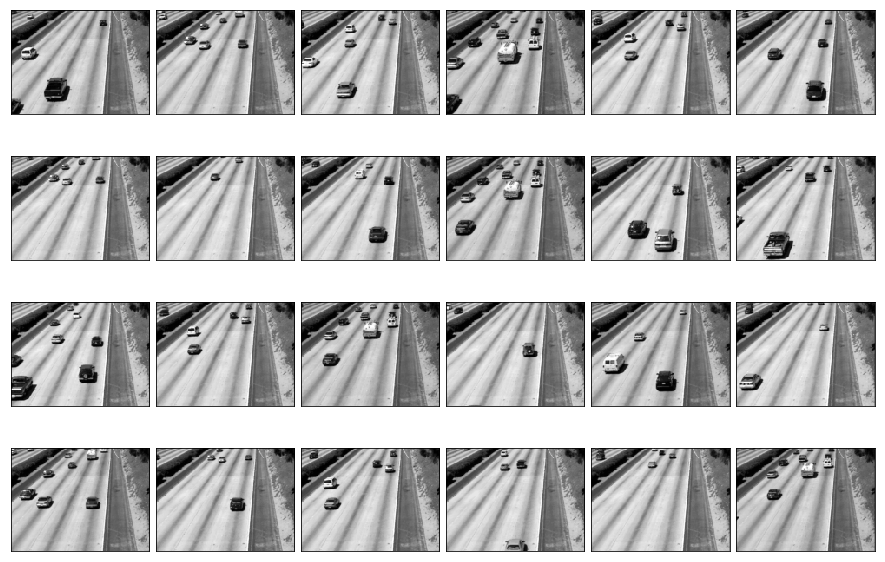

In [269]:
visualise_images(Y, n_images=24, n_columns=6)
plt.savefig('./video.png')

In [266]:
low_rank_part, sparse_part = robust_pca(Y, reg_E=0.01, learning_rate=1.2, n_iter_max=50)

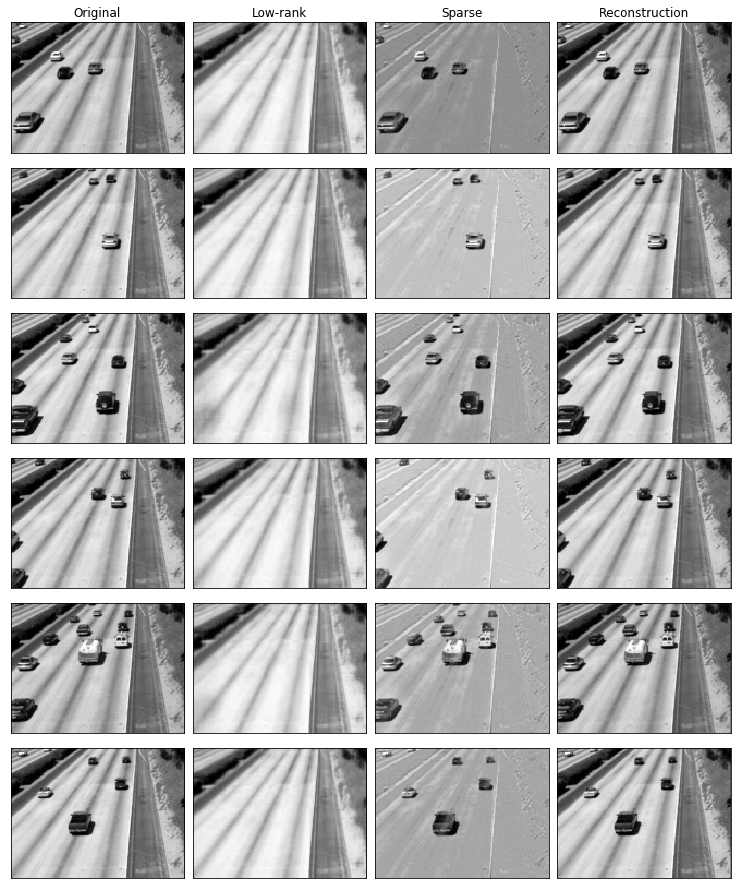

In [271]:
visualise_rpca(Y, low_rank_part, sparse_part, n_images=6)
plt.savefig('./PCA_video.png')

In [270]:
plt.savefig('./PCA_video.png')

<Figure size 432x288 with 0 Axes>

In [272]:
from iopy2.video import ffmpeg_image_list_to_video

In [273]:
def normalise(array):
    """Renormalise the array in the range [0, 255]
        
        Return an array of uint8 with 3 channels
    """
    if array.min() < 0 or array.max()>255:
        array = array - array.min()
        array /= array.max()
        array *= 255
    normalised = np.empty(list(array.shape) + [3])
    for i in range(3):
        normalised[..., i] = array
    return normalised.astype(np.uint8)

In [274]:
video_img = np.concatenate((normalise(Y), normalise(low_rank_part), normalise(sparse_part)), axis=2)


In [275]:
ffmpeg_image_list_to_video('campus_RPCA.mp4', video_img, fps=10)

Creating the video:  [██████████████████████████████████████████████████] 100%  Processing frame 500/500Done.

In [279]:
import io
import base64
from IPython.display import HTML

def video_to_html(video_filename):
    """Function to embed a video in the web page
    
    Inspired from: 
    http://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook
    """
    ext = video_filename.split('.')[-1]
    video = io.open('campus_RPCA.mp4', 'rb').read()
    encoded = base64.b64encode(video)
    return HTML(data="".format(encoded.decode('ascii'), ext))

In [278]:
video_to_html('campus_RPCA_short.mp4')